In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [31]:
rssi_df = pd.read_csv('rssi_data.csv')
pos_df = pd.read_csv('position_data.csv')
la_df = pd.read_csv('la_data.csv')

In [55]:
rssi_df.head()

,RSSI,Name,Timestamp
0,-50,egopi1,0
1,-88,egopi3,85
2,-50,egopi1,122
3,-72,egopi2,156
4,-86,egopi3,205


In [33]:
rssi_df = rssi_df[rssi_df.Name.str.startswith('egopi')]

In [54]:
pos_df.head()

,PosX,PosY,Timestamp
0,6.935874,6.364674,0
2,8.885263,6.324728,4549
3,6.935874,4.287500,8884
4,8.659247,3.768207,11320
5,7.896443,1.597826,14245


In [35]:
pos_df.drop(1, inplace=True, axis=0)

In [36]:
rssi_df.Timestamp = rssi_df.Timestamp - rssi_df.Timestamp.min()
pos_df.Timestamp = pos_df.Timestamp - pos_df.Timestamp.min()

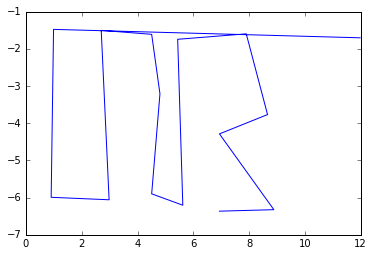

In [37]:
plt.plot(pos_df.PosX, -pos_df.PosY)

In [67]:
rssi_with_pos = rssi_df.copy()

In [68]:
rssi_with_pos.head()

,RSSI,Name,Timestamp
0,-50,egopi1,0
1,-88,egopi3,85
2,-50,egopi1,122
3,-72,egopi2,156
4,-86,egopi3,205


In [75]:
for t in rssi_with_pos.itertuples():
    ts = int(t.Timestamp)
    first_point = pos_df[pos_df.Timestamp <= ts].tail(1)
    second_point = pos_df[pos_df.Timestamp > ts].head(1)
    first_ts = int(first_point.Timestamp)
    second_ts = int(second_point.Timestamp)
    ts -= first_ts
    second_ts -= first_ts
    posX1 = float(first_point.PosX)
    posX2 = float(second_point.PosX)
    posY1 = float(first_point.PosY)
    posY2 = float(second_point.PosY)
    rssi_with_pos.loc[t.Index, 'PosX'] = posX1 + (posX2 - posX1) * ts / second_ts
    rssi_with_pos.loc[t.Index, 'PosY'] = posY1 + (posY2 - posY1) * ts / second_ts

In [76]:
rssi_with_pos.head()

,RSSI,Name,Timestamp,PosX,PosY
0,-50,egopi1,0,6.935874,6.364674
1,-88,egopi3,85,6.972299,6.363928
2,-50,egopi1,122,6.988155,6.363603
3,-72,egopi2,156,7.002725,6.363304
4,-86,egopi3,205,7.023723,6.362874


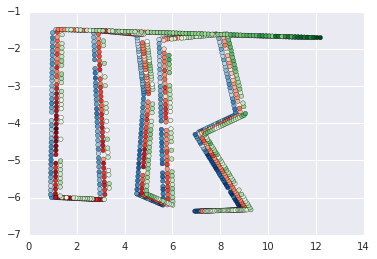

In [326]:
plt.scatter(rssi_with_pos[rssi_with_pos.Name == 'egopi1'].PosX,
            -rssi_with_pos[rssi_with_pos.Name == 'egopi1'].PosY,
            marker='o',
            c=rssi_with_pos[rssi_with_pos.Name == 'egopi1'].RSSI, cmap='Blues')

plt.scatter(rssi_with_pos[rssi_with_pos.Name == 'egopi2'].PosX+0.2,
            -rssi_with_pos[rssi_with_pos.Name == 'egopi2'].PosY,
            marker='o',
            c=rssi_with_pos[rssi_with_pos.Name == 'egopi2'].RSSI, cmap='Reds')

plt.scatter(rssi_with_pos[rssi_with_pos.Name == 'egopi3'].PosX+0.4,
            -rssi_with_pos[rssi_with_pos.Name == 'egopi3'].PosY,
            marker='o',
            c=rssi_with_pos[rssi_with_pos.Name == 'egopi3'].RSSI, cmap='Greens')

In [339]:
rssi1 = rssi_with_pos[rssi_with_pos.Name == 'egopi1']
rssi2 = rssi_with_pos[rssi_with_pos.Name == 'egopi2']
rssi3 = rssi_with_pos[rssi_with_pos.Name == 'egopi3']

In [337]:
from statsmodels.nonparametric.smoothers_lowess import lowess

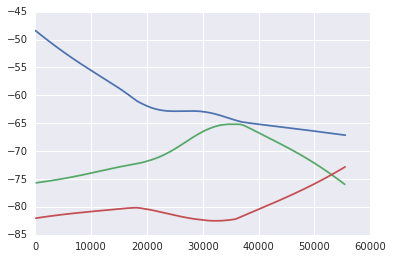

In [345]:
smoothed1 = lowess(rssi1.RSSI, rssi1.Timestamp)
plt.plot(smoothed1[:, 0], smoothed1[:, 1])

smoothed2 = lowess(rssi2.RSSI, rssi2.Timestamp)
plt.plot(smoothed2[:, 0], smoothed2[:, 1])

smoothed3 = lowess(rssi3.RSSI, rssi3.Timestamp)
plt.plot(smoothed3[:, 0], smoothed3[:, 1])


In [346]:
print(len(smoothed1))
print(len(smoothed2))
print(len(smoothed3))

426
405
345


In [388]:
def build_bins(data, dtd, n_bins=100):
    bin_w = (data.max() - data.min()) / float(n_bins-1)
    result = [[] for _ in range(n_bins)]
    for el_d, el_td in zip(data, dtd):
        result[int(el_d // bin_w)].append(el_td)
    return result

In [394]:
def fill_empty_bins(bins):
    for i, b in enumerate(bins):
        if len(b) == 0:
            bins[i].append(np.mean(np.hstack((bins[i-1], bins[i+1]))))
    

In [407]:
rssi_bins1 = build_bins(smoothed1[:, 0], smoothed1[:, 1])
rssi_bins2 = build_bins(smoothed2[:, 0], smoothed2[:, 1])
rssi_bins3 = build_bins(smoothed3[:, 0], smoothed3[:, 1])

In [408]:
fill_empty_bins(rssi_bins1)
fill_empty_bins(rssi_bins2)
fill_empty_bins(rssi_bins3)

In [409]:
posx_bins = build_bins(rssi_with_pos.Timestamp, rssi_with_pos.PosX)
posy_bins = build_bins(rssi_with_pos.Timestamp, rssi_with_pos.PosY)

In [412]:
base = []
for r1, r2, r3, x, y in zip(rssi_bins1, rssi_bins2, rssi_bins3, posx_bins, posy_bins):
    base.append(((np.mean(r1), np.mean(r2), np.mean(r3)), (np.mean(x), np.mean(y))))

In [414]:
from scipy.spatial.distance import euclidean
    

In [432]:
def find_closest(base, rssi):
    closest = None
    closest_dist = np.inf
    for b in base:
        dist = euclidean(b[0], rssi)
        if dist < closest_dist:
            closest_dist = dist
            closest = b
    return closest

In [440]:
def find_n_closest(base, rssi, n=10):
    closest = []
    closest_dist = np.inf
    for b in base:
        closest.append((b, euclidean(b[0], rssi)))
    return [x[0] for x in sorted(closest, key=lambda x: x[1])[:n]]

In [453]:
print(rssi_bins1[3])
print(rssi_bins2[3])
print(rssi_bins3[3])

[-49.794662988212707, -49.890882264542782, -50.08713146975775]
[-75.453373616399844, -75.434732921133573, -75.415507300901695, -75.396439117922384]
[-81.774624810331076, -81.756825772382513, -81.739145673149054, -81.72130912289424]


In [454]:
closest = find_n_closest(base, (-49.794, -75.39, -81.721), 5)

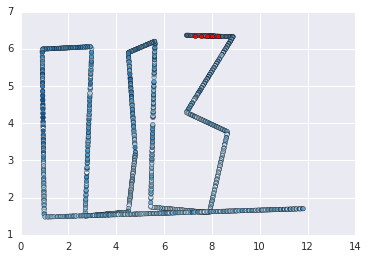

In [455]:
plt.scatter(rssi_with_pos.PosX,
            rssi_with_pos.PosY,
            c=rssi_with_pos.RSSI, cmap='Blues')
x = [x[1][0] for x in closest]
y = [x[1][1] for x in closest]
plt.scatter(x, y, c='red')

In [288]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

In [300]:
data = rssi_with_pos[rssi_with_pos.Name == 'egopi1'][['PosX', 'PosY']].as_matrix()

In [301]:
features = PolynomialFeatures(degree=3)
data = features.fit_transform(data)

In [302]:
rssi = -rssi_with_pos[rssi_with_pos.Name == 'egopi1'].RSSI.as_matrix()

In [303]:
lr = RandomForestRegressor(n_estimators=200)#LinearRegression()

In [304]:
lr.fit(data, rssi)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [305]:
testX = np.linspace(0, 12, num=100)
testY = np.linspace(0, 7, num=100)

In [306]:
testX, testY = np.meshgrid(testX, testY)

In [307]:
testX = testX.reshape(-1, 1)
testY = testY.reshape(-1, 1)

In [308]:
data.shape

(426, 10)

In [309]:
test = np.hstack((testX, testY))

In [310]:
test.shape

(10000, 2)

In [311]:
test = features.fit_transform(np.hstack((testX, testY)))

In [312]:
res = lr.predict(test)

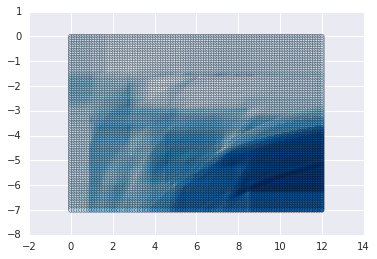

In [313]:
plt.scatter(testX, -testY, c=-res, cmap='Blues')
#plt.scatter(rssi_with_pos[rssi_with_pos.Name == 'egopi1'].PosX,
#            -rssi_with_pos[rssi_with_pos.Name == 'egopi1'].PosY,
#            c=rssi_with_pos[rssi_with_pos.Name == 'egopi1'].RSSI, cmap='Blues')

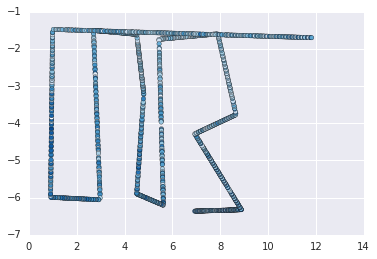